In [17]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objects as go
import networkx as nx
import pandas as pd

app = dash.Dash(__name__)

# Load CSV file directly into a DataFrame
csv_file_path = "C:/Users/bushr/Downloads/experiment_data.csv" 

# Read the CSV file
df = pd.read_csv(csv_file_path)

required_columns = ['sender_id', 'receiver_id', 'time_from_start']
df = df.dropna(subset=required_columns)

# Convert time_from_start to seconds
def time_to_seconds(time_str):
    try:
        parts = list(map(int, time_str.split(':')))
        if len(parts) == 3:  # HH:MM:SS
            h, m, s = parts
        elif len(parts) == 2:  # MM:SS
            h, m, s = 0, parts[0], parts[1]
        else:
            raise ValueError("Invalid time format")
        return h * 3600 + m * 60 + s
    except Exception:
        return None  # Return None for invalid or missing data

df['time_from_start_seconds'] = df['time_from_start'].apply(time_to_seconds)
df = df.dropna(subset=['time_from_start_seconds'])

# Create directed graph from CSV data
G = nx.from_pandas_edgelist(
    df,
    source='sender_id',
    target='receiver_id',
    edge_attr='time_from_start_seconds',
    create_using=nx.DiGraph()
)

# Create 2D and 3D positions for nodes
pos_2d = nx.spring_layout(G, seed=42)
pos_3d = nx.spring_layout(G, dim=3, seed=42)

# Remove NaN positions if any
pos_2d = {node: pos for node, pos in pos_2d.items() if not any(pd.isna(coord) for coord in pos)}
pos_3d = {node: pos for node, pos in pos_3d.items() if not any(pd.isna(coord) for coord in pos)}

# Define layout
app.layout = html.Div([
    html.H1("Network Graph Analysis"),
    dcc.Dropdown(
        id='layout-dropdown',
        options=[
            {'label': '2D Layout', 'value': '2d'},
            {'label': '3D Layout', 'value': '3d'}
        ],
        value='2d',
        style={'width': '50%'}
    ),
    dcc.Dropdown(
        id='target-nodes-dropdown',
        placeholder="Select Target Nodes",
        multi=True,
        style={'width': '50%'}
    ),
    dcc.Graph(id='main-network'),
    dcc.Graph(id='subgraph')
])

@app.callback(
    [Output('target-nodes-dropdown', 'options'),
     Output('main-network', 'figure')],
    [Input('layout-dropdown', 'value')]
)
def update_graph(layout):
    # Update dropdown options for target nodes
    dropdown_options = [{'label': node, 'value': node} for node in G.nodes]

    # Create the main network graph
    fig = create_full_graph(layout)
    return dropdown_options, fig

@app.callback(
    Output('subgraph', 'figure'),
    [Input('layout-dropdown', 'value'),
     Input('target-nodes-dropdown', 'value')]
)
def update_subgraph(layout, target_nodes):
    if not target_nodes:
        return go.Figure()

    # Create subgraph with target nodes
    return create_subgraph_with_sources(target_nodes, layout)

def create_full_graph(layout='2d'):
    pos = pos_3d if layout == '3d' else pos_2d
    fig = go.Figure()

    # Add edges
    for edge in G.edges(data=True):
        fig.add_trace(go.Scatter3d(
            x=[pos[edge[0]][0], pos[edge[1]][0]],
            y=[pos[edge[0]][1], pos[edge[1]][1]],
            z=[pos[edge[0]][2], pos[edge[1]][2]] if layout == '3d' else [0, 0],
            mode='lines',
            line=dict(color='rgba(0,0,0,0.5)', width=2),
            hoverinfo='skip'
        ))

    # Add nodes
    fig.add_trace(go.Scatter3d(
        x=[pos[node][0] for node in G.nodes],
        y=[pos[node][1] for node in G.nodes],
        z=[pos[node][2] for node in G.nodes] if layout == '3d' else [0] * len(G.nodes),
        mode='markers+text',
        marker=dict(size=10, color='blue', opacity=0.8),
        text=[str(node) for node in G.nodes],
        textposition='top center',
        hoverinfo='text'
    ))

    # Update layout
    fig.update_layout(
        title="Main Network Graph",
        showlegend=False,
        height=600,
        margin=dict(l=0, r=0, b=0, t=40)
    )
    return fig

def create_subgraph_with_sources(target_nodes, layout='2d'):
    pos = pos_3d if layout == '3d' else pos_2d
    sub_nodes = set()
    edges = []

    for target in target_nodes:
        predecessors = G.predecessors(target)
        earliest_source = None
        earliest_time = float('inf')
        for pred in predecessors:
            edge_time = G.edges[pred, target].get('time_from_start_seconds', float('inf'))
            if edge_time < earliest_time:
                earliest_source = pred
                earliest_time = edge_time
        if earliest_source:
            sub_nodes.update([earliest_source, target])
            edges.append((earliest_source, target))

    H = G.subgraph(sub_nodes)
    fig = go.Figure()

    # Add edges
    for edge in edges:
        fig.add_trace(go.Scatter3d(
            x=[pos[edge[0]][0], pos[edge[1]][0]],
            y=[pos[edge[0]][1], pos[edge[1]][1]],
            z=[pos[edge[0]][2], pos[edge[1]][2]] if layout == '3d' else [0, 0],
            mode='lines',
            line=dict(color='orange', width=3),
            hoverinfo='skip'
        ))

    # Add nodes
    fig.add_trace(go.Scatter3d(
        x=[pos[node][0] for node in H.nodes],
        y=[pos[node][1] for node in H.nodes],
        z=[pos[node][2] for node in H.nodes] if layout == '3d' else [0] * len(H.nodes),
        mode='markers+text',
        marker=dict(size=12, color='green', opacity=0.8),
        text=[str(node) for node in H.nodes],
        textposition='top center',
        hoverinfo='text'
    ))

    # Update layout
    fig.update_layout(
        title="Subgraph with Target Nodes",
        showlegend=False,
        height=600,
        margin=dict(l=0, r=0, b=0, t=40)
    )
    return fig

if __name__ == '__main__':
    app.run_server(debug=True)


In [1]:
import dash
from dash import dcc, html
import plotly.graph_objects as go
import networkx as nx
import pandas as pd
import numpy as np

df_csv = pd.read_csv("C:/Users/bushr/Downloads/updated.csv")

G = nx.from_pandas_edgelist(df_csv, source='source', target='target', create_using=nx.DiGraph())

# Create a dictionary of positions for consistent layout (including 3D)
pos_2d = nx.spring_layout(G, seed=42)  # Default 2D layout
pos_3d = nx.spring_layout(G, dim=3, seed=42)  # 3D layout

# Function to get node degree
def get_node_degree(node):
    return G.degree(node)

# Function to get in-degree for a node
def get_node_in_degree(node):
    return G.in_degree(node)

# Function to create the main network graph with directed edges
def create_full_graph(layout='2d'):
    # Choose layout based on the input
    pos = pos_3d if layout == '3d' else pos_2d
    
    # Node color based on degree (just as an example)
    node_color = ['blue' if get_node_degree(node) > 2 else 'lightgray' for node in G.nodes]
    
    # Create node labels with degree info for hover
    node_labels = [f"{node}<br>In-degree: {get_node_degree(node)}" for node in G.nodes]

    fig = go.Figure()

    # Add directed edges (arrows) with new edge styling (dashed, varying thickness, color)
    for edge in G.edges():
        fig.add_trace(go.Scatter3d(
            x=[pos[edge[0]][0], pos[edge[1]][0]],
            y=[pos[edge[0]][1], pos[edge[1]][1]],
            z=[pos[edge[0]][2] if layout == '3d' else 0, pos[edge[1]][2] if layout == '3d' else 0],
            mode='lines',
            line=dict(color='rgba(0,0,0,0.5)', width=2, dash='dot'),  # Dashed edges with gray color
            hoverinfo='skip'
        ))

    # Add nodes with hover information
    fig.add_trace(go.Scatter3d(
        x=[pos[node][0] for node in G.nodes],
        y=[pos[node][1] for node in G.nodes],
        z=[pos[node][2] for node in G.nodes] if layout == '3d' else [0] * len(G.nodes),
        mode='markers+text',
        marker=dict(size=15, color=node_color, opacity=0.8),
        text=node_labels,
        textposition='top center',
        hoverinfo='text'
    ))

    # Style the layout
    fig.update_layout(
        title="Main Network Graph with Directed Edges (3D)",
        showlegend=False,
        scene=dict(
            xaxis=dict(title='X', visible=True),
            yaxis=dict(title='Y', visible=True),
            zaxis=dict(title='Z', visible=True) if layout == '3d' else None
        ),
        plot_bgcolor='lightgray',
        height=600,
        margin=dict(l=0, r=0, b=0, t=40)
    )

    return fig

# Initialize Dash app
app = dash.Dash(__name__)

# Layout with interactive components
app.layout = html.Div([
    html.H1("Interactive 3D Network Graph with Subgraph and Animation"),
    
    # Dropdown for layout selection
    dcc.Dropdown(
        id='layout-dropdown',
        options=[
            {'label': '2D Layout', 'value': '2d'},
            {'label': '3D Layout', 'value': '3d'}
        ],
        value='2d',  # Default to 2D
        style={'width': '50%'}
    ),
    
    # Dropdown to select multiple target nodes
    dcc.Dropdown(
        id='target-nodes-dropdown',
        options=[{'label': node, 'value': node} for node in G.nodes],
        multi=True,
        placeholder="Select target nodes",
        style={'width': '50%'}
    ),
    
    # Graph components to display the graphs
    dcc.Graph(id='main-network'),
    dcc.Graph(id='subgraph')
])

# Callback to update the layout and animation based on dropdown selections
@app.callback(
    [dash.dependencies.Output('main-network', 'figure'),
     dash.dependencies.Output('subgraph', 'figure')],
    [dash.dependencies.Input('layout-dropdown', 'value'),
     dash.dependencies.Input('target-nodes-dropdown', 'value')]
)
def update_graph(layout, target_nodes):
    # Update the main graph
    main_graph = create_full_graph(layout)
    
    # Update the subgraph with animation if target nodes are selected
    if target_nodes:
        subgraph = create_subgraph_with_animation(target_nodes, layout)
    else:
        subgraph = go.Figure()
    
    return main_graph, subgraph

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)


In [27]:
import dash
from dash import dcc, html
import plotly.graph_objects as go
import networkx as nx
import pandas as pd
import numpy as np
import plotly.express as px

# Load the updated dataset
df_csv = pd.read_csv("C:/Users/bushr/Downloads/experiment_data.csv")

# Convert 'time_from_start' to seconds for edge attributes
def time_to_seconds(time_str):
    try:
        parts = list(map(int, time_str.split(':')))
        if len(parts) == 3:  # HH:MM:SS
            h, m, s = parts
        elif len(parts) == 2:  # MM:SS
            h, m, s = 0, parts[0], parts[1]
        else:
            raise ValueError("Invalid time format")
        return h * 3600 + m * 60 + s
    except Exception:
        return None

df_csv['time_from_start_seconds'] = df_csv['time_from_start'].apply(time_to_seconds)

# Filter out rows with missing data for the graph
df_csv = df_csv.dropna(subset=['sender_id', 'receiver_id', 'time_from_start_seconds'])

# Create a directed graph from the data
G = nx.from_pandas_edgelist(
    df_csv,
    source='sender_id',
    target='receiver_id',
    edge_attr='time_from_start_seconds',
    create_using=nx.DiGraph()
)

# Create consistent layouts for 2D and 3D graphs
pos_2d = nx.spring_layout(G, seed=42)  # 2D layout
pos_3d = nx.spring_layout(G, dim=3, seed=42)  # 3D layout

# Function to get node degree
def get_node_degree(node):
    return G.degree(node)

# Function to create the main network graph with animation
def create_full_graph_with_animation(source_node=None, layout='2d'):
    pos = pos_3d if layout == '3d' else pos_2d
    node_color = ['blue' if get_node_degree(node) > 2 else 'lightgray' for node in G.nodes]
    node_labels = [f"{node}<br>Degree: {get_node_degree(node)}" for node in G.nodes]

    frames = []

    # Filter edges if a source node is selected
    edges = [(u, v, d) for u, v, d in G.edges(data=True) if source_node is None or u == source_node]

    # Create animation frames
    for edge in edges:
        x_start, x_end = pos[edge[0]][0], pos[edge[1]][0]
        y_start, y_end = pos[edge[0]][1], pos[edge[1]][1]
        z_start, z_end = (pos[edge[0]][2], pos[edge[1]][2]) if layout == '3d' else (0, 0)

        frame = go.Scatter3d(
            x=[x_start, x_end],
            y=[y_start, y_end],
            z=[z_start, z_end],
            mode='lines',
            line=dict(color='rgba(0,0,255,0.8)', width=3),
            hoverinfo='skip'
        ) if layout == '3d' else go.Scatter(
            x=[x_start, x_end],
            y=[y_start, y_end],
            mode='lines',
            line=dict(color='rgba(0,0,255,0.8)', width=3),
            hoverinfo='skip'
        )
        frames.append(frame)

    # Create the figure
    fig = go.Figure()

    # Add initial edges
    for edge in edges:
        fig.add_trace(go.Scatter3d(
            x=[pos[edge[0]][0], pos[edge[1]][0]],
            y=[pos[edge[0]][1], pos[edge[1]][1]],
            z=[pos[edge[0]][2] if layout == '3d' else 0, pos[edge[1]][2] if layout == '3d' else 0],
            mode='lines',
            line=dict(color='rgba(0,0,0,0.5)', width=2),
            hoverinfo='skip'
        ))

    # Add nodes
    fig.add_trace(go.Scatter3d(
        x=[pos[node][0] for node in G.nodes],
        y=[pos[node][1] for node in G.nodes],
        z=[pos[node][2] for node in G.nodes] if layout == '3d' else [0] * len(G.nodes),
        mode='markers+text',
        marker=dict(size=15, color=node_color, opacity=0.8),
        text=node_labels,
        textposition='top center',
        hoverinfo='text'
    ))

    # Add animation frames
    fig.frames = [go.Frame(data=[frame]) for frame in frames]

    fig.update_layout(
        title="Main Network Graph with Animation",
        showlegend=False,
        scene=dict(
            xaxis=dict(title='X'),
            yaxis=dict(title='Y'),
            zaxis=dict(title='Z') if layout == '3d' else None
        ),
        height=600,
        margin=dict(l=0, r=0, b=0, t=40),
        updatemenus=[
            dict(
                type="buttons",
                showactive=False,
                buttons=[
                    dict(label="Play",
                         method="animate",
                         args=[None, dict(frame=dict(duration=500, redraw=True),
                                          fromcurrent=True)])
                ]
            )
        ]
    )

    return fig

# Initialize the Dash app
app = dash.Dash(__name__)

# Layout for the app
app.layout = html.Div([
    html.H1("Network Graph Visualization"),
    dcc.Dropdown(
        id='layout-dropdown',
        options=[
            {'label': '2D Layout', 'value': '2d'},
            {'label': '3D Layout', 'value': '3d'}
        ],
        value='2d',
        style={'width': '50%'}
    ),
    dcc.Dropdown(
        id='source-node-dropdown',
        options=[{'label': node, 'value': node} for node in G.nodes],
        placeholder="Select source node",
        style={'width': '50%'}
    ),
    dcc.Graph(id='main-network')
])


# Callback to update the graph based on the selected layout and source node
@app.callback(
    dash.dependencies.Output('main-network', 'figure'),
    [dash.dependencies.Input('layout-dropdown', 'value'),
     dash.dependencies.Input('source-node-dropdown', 'value')]
)
def update_graph(layout, source_node):
    return create_full_graph_with_animation(source_node, layout)

if __name__ == '__main__':
    app.run_server(debug=True)


In [43]:
import dash
from dash import dcc, html
import dash_cytoscape as cyto

# Create elements for Cytoscape
elements = []
for _, row in df_csv.iterrows():
    # Add nodes
    elements.append({'data': {'id': row['source'], 'label': row['source'], 'group': row['label']}})
    elements.append({'data': {'id': row['target'], 'label': row['target'], 'group': 'true'}})
    
    # Add edges
    elements.append({'data': {'source': row['source'], 'target': row['target']}})

# Define the app
app = dash.Dash(__name__)
app.layout = html.Div([
    html.H1("Interactive Network Visualization"),
    cyto.Cytoscape(
        id='cytoscape-network',
        elements=elements,
        style={'width': '100%', 'height': '600px'},
        layout={'name': 'cose'},  # Force-directed layout
        stylesheet=[
            {'selector': 'node[group = "fake"]', 'style': {'background-color': 'red'}},
            {'selector': 'node[group = "true"]', 'style': {'background-color': 'green'}},
            {'selector': 'edge', 'style': {'line-color': 'gray'}}
        ]
    )
])

if __name__ == '__main__':
    app.run_server(debug=True)


In [ ]:
import plotly.graph_objects as go
import pandas as pd

# Load your CSV data
df_csv = pd.read_csv("C:/Users/bushr/Downloads/updated.csv")

# Prepare data for Sankey Diagram
label_nodes = list(set(df_csv['source']).union(set(df_csv['target'])))
label_colors = ['red' if node in df_csv[df_csv['label'] == 'fake']['source'].values else 'green' for node in label_nodes]

# Map nodes to indices
node_map = {node: i for i, node in enumerate(label_nodes)}
source_indices = df_csv['source'].map(node_map)
target_indices = df_csv['target'].map(node_map)

# Create the Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15, thickness=20, label=label_nodes, color=label_colors
    ),
    link=dict(
        source=source_indices, 
        target=target_indices, 
        value=[1] * len(df_csv),  # Uniform weight for each connection
        color=['rgba(0, 0, 0, 0.3)'] * len(df_csv)  # Link color
    )
))

# Update the layout and display the plot
fig.update_layout(title_text="Sankey Diagram of Fake and True Nodes", font_size=10)
fig.show()


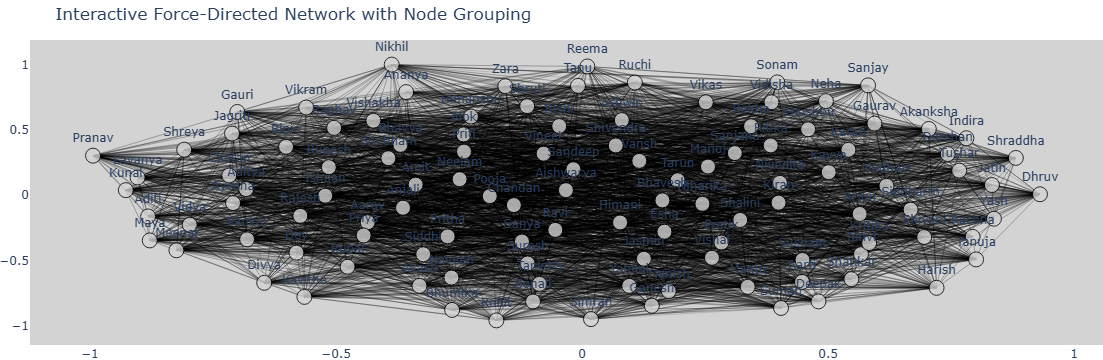

In [70]:
import plotly.graph_objects as go
import pandas as pd
import networkx as nx
import numpy as np

# Load your CSV data
df_csv = pd.read_csv("C:/Users/bushr/Downloads/updated.csv")

# Create a directed graph using NetworkX
G = nx.from_pandas_edgelist(df_csv, source='source', target='target', create_using=nx.DiGraph())

# Create a force-directed layout for positioning the nodes
pos = nx.spring_layout(G, seed=42)  # Force-directed layout

# Group nodes into two categories (e.g., based on 'label')
label_fake_nodes = df_csv[df_csv['label'] == 'fake']['source'].values
label_true_nodes = df_csv[df_csv['label'] == 'true']['source'].values

# Set node color based on label
node_colors = []
for node in G.nodes:
    if node in label_fake_nodes:
        node_colors.append('red')  # Fake nodes in red
    elif node in label_true_nodes:
        node_colors.append('green')  # True nodes in green
    else:
        node_colors.append('lightgray')  # Default color for other nodes

# Create the edge list for the visualization
edge_x = []
edge_y = []
edge_z = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_z.append(0)  # For 2D, we use z=0 for all edges

# Create the node positions
node_x = [pos[node][0] for node in G.nodes]
node_y = [pos[node][1] for node in G.nodes]
node_z = [0] * len(G.nodes)  # For 2D, all nodes lie in the z=0 plane

# Create the node labels
node_labels = [f"{node}" for node in G.nodes]

# Create the Plotly figure
fig = go.Figure()

# Add edges to the plot (lines connecting nodes)
fig.add_trace(go.Scatter(
    x=edge_x, y=edge_y, mode='lines', line=dict(width=0.5, color='rgba(0,0,0,0.3)'),
    hoverinfo='skip'
))

# Add nodes to the plot
fig.add_trace(go.Scatter(
    x=node_x, y=node_y, mode='markers+text', 
    marker=dict(
        size=15, color=node_colors, opacity=0.8, line=dict(width=1, color='black')
    ),
    text=node_labels, textposition='top center', hoverinfo='text'
))

# Update the layout
fig.update_layout(
    title="Interactive Force-Directed Network with Node Grouping",
    showlegend=False,
    plot_bgcolor='lightgray',
    height=600,
    margin=dict(l=0, r=0, b=0, t=40),
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(showgrid=False, zeroline=False),
)

# Show the figure in a Jupyter notebook
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)
pyo.iplot(fig)


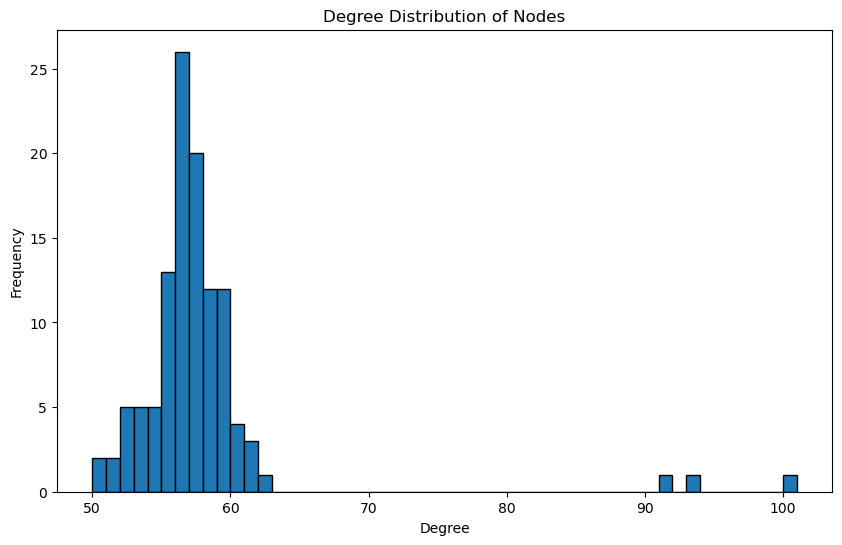

In [72]:
import matplotlib.pyplot as plt

# Calculate the degree of each node
degrees = [G.degree(node) for node in G.nodes]

# Plot the degree distribution
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=range(min(degrees), max(degrees) + 1), edgecolor='black')
plt.title("Degree Distribution of Nodes")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()


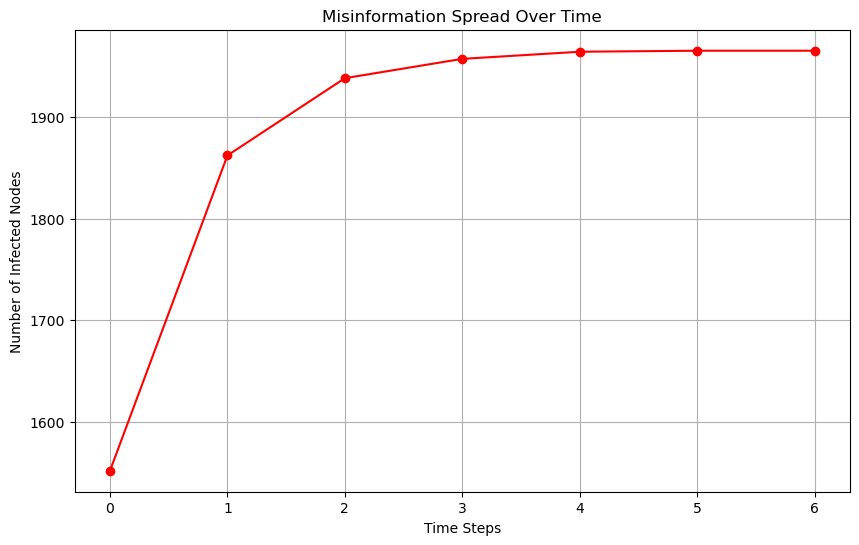

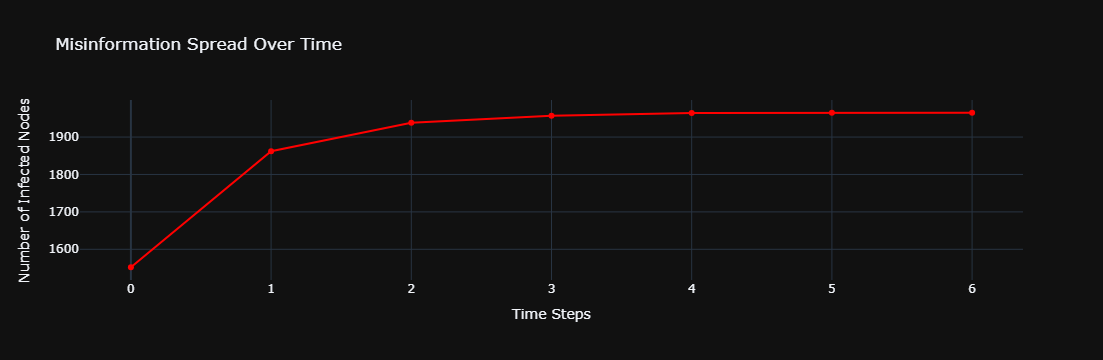

In [96]:
import pandas as pd
import networkx as nx
import random
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
# Load the dataset
df = pd.read_csv('C:/Users/bushr/Downloads/experiment_data.csv')

# Create a directed graph from the dataset
G = nx.from_pandas_edgelist(df, source='sender_id', target='receiver_id', create_using=nx.DiGraph())
# Define the initial set of infected nodes
initial_infected = random.sample(list(G.nodes), 5)  # Randomly select 5 nodes

# Create a dictionary to track the infection status of each node
infected = {node: False for node in G.nodes}
for node in initial_infected:
    infected[node] = True
# Set the probability of misinformation spreading
infection_prob = 0.2  # 20% chance of spreading

# Function to simulate the spread of misinformation over time
def simulate_spread(G, infected, prob):
    new_infected = set()
    for node in infected:
        for neighbor in G.neighbors(node):
            if not infected[neighbor] and random.random() < prob:
                new_infected.add(neighbor)
                infected[neighbor] = True
    return new_infected
# Track the number of infected nodes over time
infected_count_over_time = []
iterations = 20  # Run for 20 time steps

for i in range(iterations):
    new_infected = simulate_spread(G, infected, infection_prob)
    infected_count_over_time.append(sum(infected.values()))
    
    if not new_infected:  # No more spread possible
        break

# Visualize the spread of misinformation over time
plt.figure(figsize=(10, 6))
plt.plot(range(len(infected_count_over_time)), infected_count_over_time, marker='o', color='red')
plt.title("Misinformation Spread Over Time")
plt.xlabel("Time Steps")
plt.ylabel("Number of Infected Nodes")
plt.grid(True)
plt.show()
# Plotly interactive time-based visualization
time_steps = list(range(len(infected_count_over_time)))
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=time_steps,
    y=infected_count_over_time,
    mode='lines+markers',
    name='Infected Nodes',
    line=dict(color='red', width=2)
))

fig.update_layout(
    title="Misinformation Spread Over Time",
    xaxis_title="Time Steps",
    yaxis_title="Number of Infected Nodes",
    template="plotly_dark"
)

fig.show()


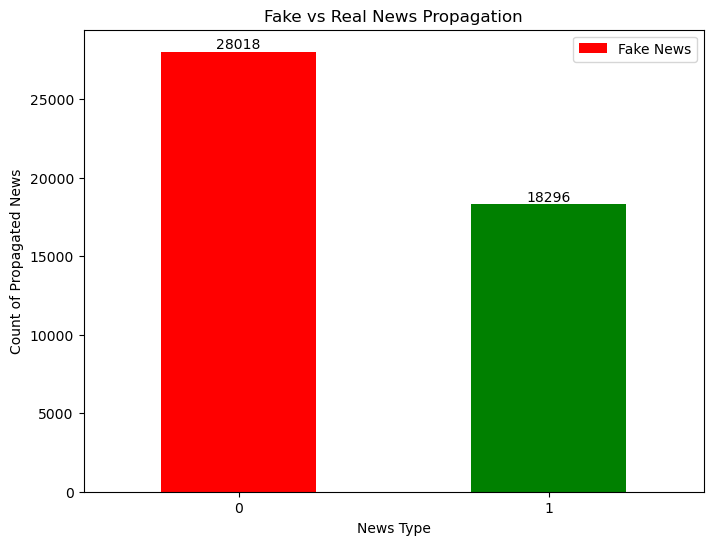

In [121]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your dataset
df = pd.read_csv("C:/Users/bushr/Downloads/experiment_data.csv")

df_clean = df.dropna(subset=['fake'])

# Count the occurrences of each label (Fake vs Real news)
news_count = df_clean['fake'].value_counts()
plt.figure(figsize=(8, 6))
bars = news_count.plot(kind='bar', color=['red', 'green'])

plt.title("Fake vs Real News Propagation")
plt.xlabel("News Type")
plt.ylabel("Count of Propagated News")
plt.xticks(rotation=0)
# Add legend
bars.bar_label(bars.containers[0], labels=news_count.values)
plt.legend(["Fake News", "Real News"], loc='upper right')
plt.show()
